In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from tqdm.auto import tqdm

## Load data

In [2]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

# samples in train dataset: 60000
# samples in test dataset: 10000
Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Image shape: torch.Size([1, 28, 28])


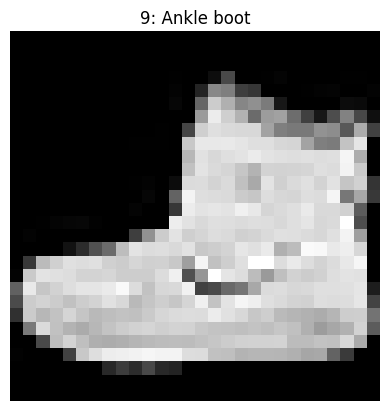

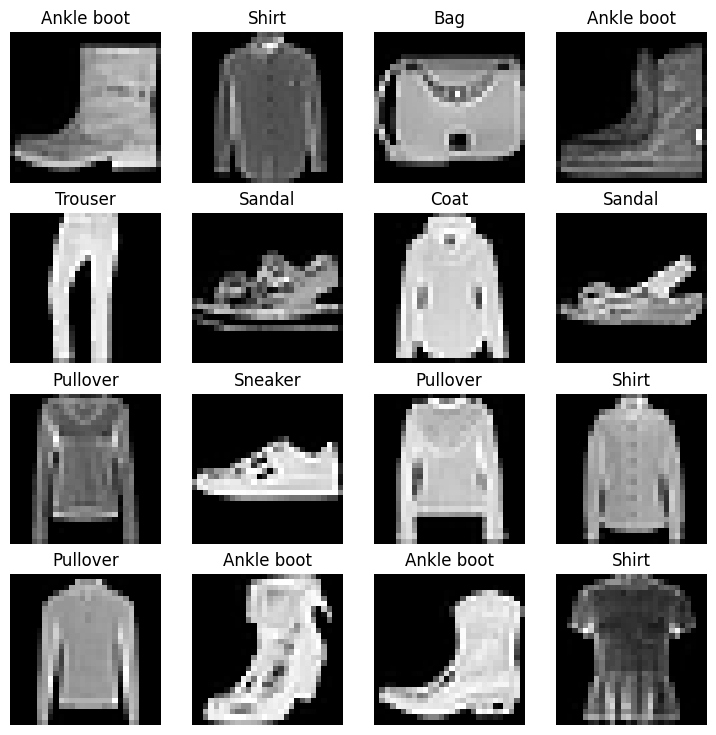

In [3]:
print(f"# samples in train dataset: {len(train_data)}")
print(f"# samples in test dataset: {len(test_data)}")
print(f"Class names: {train_data.classes}")

# Plot first sample
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze(), cmap="gray") # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(f"{label}: {train_data.classes[label]}")
plt.axis(False)
plt.show()

# Plot some random images
torch.manual_seed(42)
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
for i in range(4):
    for j in range(4):
        random_idx = torch.randint(0, len(train_data), size=[1]).item()
        img, label = train_data[random_idx]
        axs[i][j].imshow(img.squeeze(), cmap="gray")
        axs[i][j].set_title(train_data.classes[label])
        axs[i][j].axis(False)
plt.show()

Use dataloader to prepare data for training/testing, i.e. turn datasets into batches

In [19]:
BATCH_SIZE = 20

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True # shuffle data every epoch
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
)

print(f"# train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE} samples")
print(f"# test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE} samples")

# train dataloader: 3000 batches of 20 samples
# test dataloader: 500 batches of 20 samples


## Implement the model

In [5]:
# Create a convolutional neural network 
class SimpleCNN(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                    out_channels=hidden_units, 
                    kernel_size=3, # size the square/kernel that's going over the image
                    stride=1, # default
                    padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, # takes the max value of a (2x2) window
                        stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # in_features:
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7,
                        out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape) # Use this print statement to find the shape of final output.
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [6]:
class_names = train_data.classes
image_dim = train_data[0][0].squeeze().shape[0] * train_data[0][0].squeeze().shape[1]

In [7]:
image_dim

784

In [8]:
# Initialize model
torch.manual_seed(42) # set seed for random parameters in model
simple_cnn_model = SimpleCNN(
    input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)
    )

# Select optimizer and loss function
loss_fn = nn.CrossEntropyLoss() # 2d images https://neptune.ai/blog/pytorch-loss-functions
optimizer = torch.optim.SGD(
    params=simple_cnn_model.parameters(), 
    lr=0.1
    )

In [9]:
def train_model(
    model,
    data_loader,
    loss_fn,
    optimizer,
):
    """
    Training loop for 1 epoch

    Args:
        model (_type_): _description_
        data_loader (_type_): _description_
        loss_fn (_type_): _description_
        optimizer (_type_): _description_
    """
    train_loss = 0.0 # keep track of total loss
    train_acc = 0.0 # keep track of the total accuracy
    
    model.train() # Set to training mode
    for batch , (X_data, y_data) in enumerate(data_loader):
        # Forward pass - make a prediction
        y_pred = model(X_data)
        
        # Compute the loss
        loss = loss_fn(y_pred, y_data)
        train_loss += loss
        acc = torch.eq(y_pred.argmax(dim=1), y_data).sum().item() / len(y_data) * 100
        train_acc += acc
        
        # Optimizer zero grad
        optimizer.zero_grad()
        
        # Compute gradient of the loss w.r.t. to the parameters 
        loss.backward()
        
        # Optimizer will modify the parameters by consideting the gradient
        # Inside each parameter there is already a grad calculated, 
        # this applies the optimizer algorithm to the observed parameters
        optimizer.step()
        
        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X_data)}/{len(train_dataloader.dataset)} samples")
        
    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


In [10]:
train_model(
    simple_cnn_model,
    train_dataloader,
    loss_fn,
    optimizer
)

Looked at 0/60000 samples
Looked at 8000/60000 samples
Looked at 16000/60000 samples
Looked at 24000/60000 samples
Looked at 32000/60000 samples
Looked at 40000/60000 samples
Looked at 48000/60000 samples
Looked at 56000/60000 samples
Train loss: 0.52639 | Train accuracy: 80.98%


In [11]:
def test_model(
    model,
    data_loader,
    loss_fn,
    evaluate=False
):
    test_loss = 0.0 # keep track of total loss
    test_acc = 0.0 # keep track of the total accuracy
    
    model.eval() # Set to evaluation mode
    
    with torch.inference_mode(): # Turn on inference context manager
        for X_test, y_test in data_loader:
            
            # Forward pass - Inference data
            y_pred = model(X_test)
            
            # Compute loss and accuracy
            loss = loss_fn(y_pred, y_test)
            acc = torch.eq(y_pred.argmax(dim=1), y_test).sum().item() / len(y_test) * 100
            test_loss += loss
            test_acc += acc
            
        # Print metrics
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        if evaluate == True:
            return {"model_name": model.__class__.__name__,
                    "model_loss": test_loss.item(),
                    "model_acc": test_acc}
        else:
            print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        

In [12]:
test_model(
    simple_cnn_model,
    test_dataloader,
    loss_fn,
)

Test loss: 0.37220 | Test accuracy: 86.29%



In [13]:
# Train and test for multiple epochs

epochs = 5

for epoch in range(epochs):
    print(f"----> EPOCH {epoch} of {epochs}:")
    train_model(
        model=simple_cnn_model,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer
    )
    test_model(
        model=simple_cnn_model,
        data_loader=test_dataloader,
        loss_fn=loss_fn
    )

# get final result(evaluate=True)
metrics = test_model(
        model=simple_cnn_model,
        data_loader=test_dataloader,
        loss_fn=loss_fn,
        evaluate=True
    )
metrics

----> EPOCH 0 of 5:
Looked at 0/60000 samples
Looked at 8000/60000 samples
Train loss: 0.38748 | Train accuracy: 86.30%
Test loss: 0.38692 | Test accuracy: 85.02%

----> EPOCH 1 of 5:
Looked at 0/60000 samples
Looked at 8000/60000 samples
Train loss: 0.35884 | Train accuracy: 87.32%
Test loss: 0.36966 | Test accuracy: 85.76%

----> EPOCH 2 of 5:
Looked at 0/60000 samples
Looked at 8000/60000 samples
Train loss: 0.34278 | Train accuracy: 87.78%
Test loss: 0.35314 | Test accuracy: 86.40%

----> EPOCH 3 of 5:
Looked at 0/60000 samples
Looked at 8000/60000 samples
Train loss: 0.33293 | Train accuracy: 88.32%
Test loss: 0.33550 | Test accuracy: 87.02%

----> EPOCH 4 of 5:
Looked at 0/60000 samples
Looked at 8000/60000 samples
Train loss: 0.32175 | Train accuracy: 88.53%
Test loss: 0.32419 | Test accuracy: 87.68%



{'model_name': 'SimpleCNN',
 'model_loss': 0.32418912649154663,
 'model_acc': 87.68}

## Evaluate predictions 

In [14]:
def make_predictions(model, data):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob)
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [15]:
# Random sample from test dataset

random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [16]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=simple_cnn_model, 
                            data=test_samples)

# View first two prediction probabilities list
print(f"pred_probs: {pred_probs[:2]}")

# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)

print(f"pred classes: {pred_classes}")
print(f"test labels: {test_labels}")

pred_probs: tensor([[1.2458e-10, 1.8410e-12, 8.0819e-10, 1.2245e-10, 2.6165e-10, 1.0000e+00,
         8.6743e-10, 2.0359e-09, 7.9990e-08, 2.5891e-07],
        [2.0482e-01, 3.0510e-01, 6.4082e-04, 2.4591e-02, 2.3179e-02, 3.1115e-04,
         4.4127e-01, 1.4519e-05, 6.0727e-05, 1.8061e-05]])
pred classes: tensor([5, 6, 7, 4, 3, 6, 4, 7, 1])
test labels: [5, 1, 7, 4, 3, 0, 4, 7, 1]


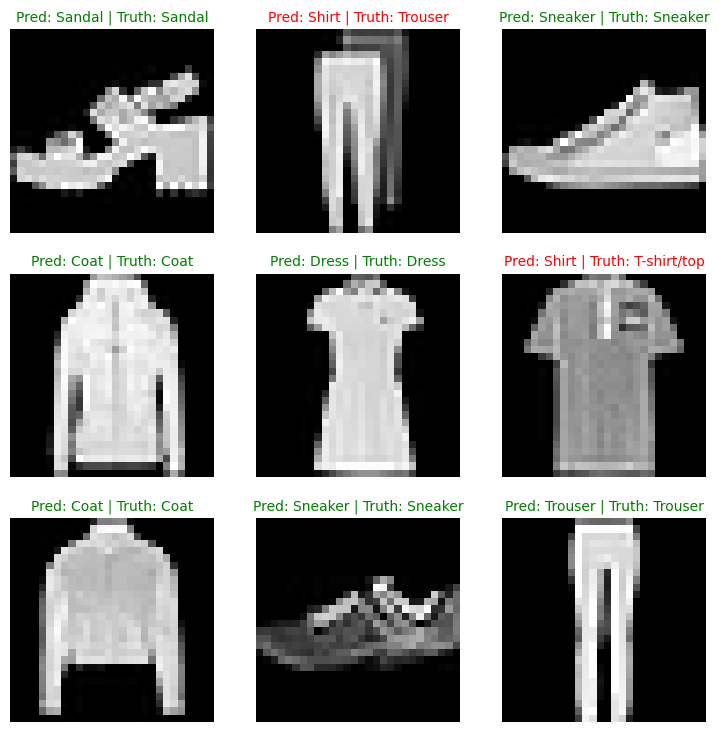

In [17]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")

    # Find the prediction label (in text form, e.g. "Sandal")
    pred_label = class_names[pred_classes[i]]

    # Get the truth label (in text form, e.g. "T-shirt")
    truth_label = class_names[test_labels[i]] 

    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    
    # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r") # red text if wrong
    plt.axis(False)

Making predictions:   0%|          | 0/500 [00:00<?, ?it/s]

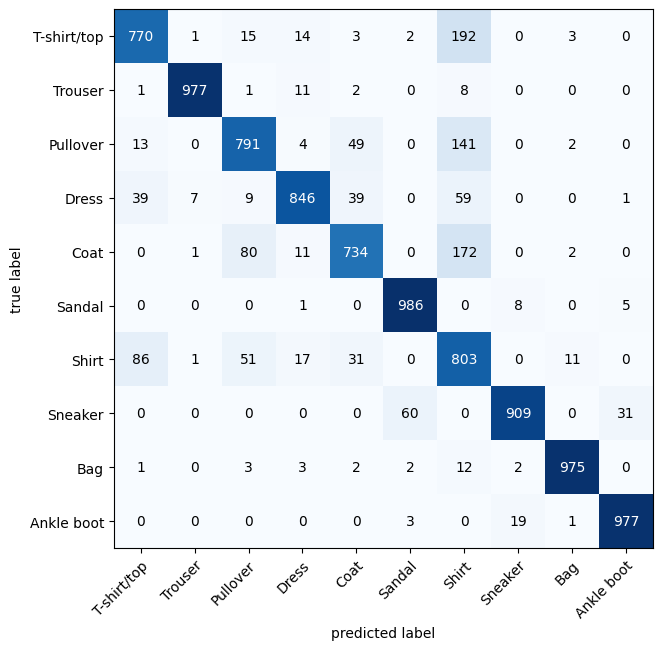

In [18]:
# Confusion matrix
def compute_confusion_matrix(model, data_loader):
  
  # Make predictions with trained model
  y_preds = []
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader, desc="Making predictions"):
      # Do the forward pass
      y_logit = model(X)
      # Turn predictions from logits -> prediction probabilities -> predictions labels
      y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
      # Put predictions on CPU for evaluation
      y_preds.append(y_pred)
      
  # Concatenate list of predictions into a tensor
  y_pred_tensor = torch.cat(y_preds)
  
  # Setup confusion matrix instance and compare predictions to targets
  confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
  confmat_tensor = confmat(preds=y_pred_tensor,
                          target=test_data.targets)
  return confmat_tensor

confmat_tensor = compute_confusion_matrix(
  model=simple_cnn_model,
  data_loader=test_dataloader
)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)